In [15]:
import os
os.chdir("..")  # Moves one directory up

In [17]:
import pandas as pd 
import numpy as np 
from utils.config import base_path
from preprocessing.preprocess import concat_metadata_with_gene_expression,prepare_dataset_for_feature_selection,normalize_features
from preprocessing.feature_selection import getting_best_features
from sklearn.model_selection import train_test_split
from models.model_training import train_xgboost_classifier
from models.model_evaluation import ModelEvaluator

In [18]:
gene_expression = pd.read_csv(base_path/ "gene_expression.csv")
meta_data = pd.read_csv(base_path/ "meta_data.csv")

df = concat_metadata_with_gene_expression(meta_data,gene_expression,filter_nan_target=True)
df.head()

,SampleID,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,Tissue,disease state,protocol,disease activity score (das28),Response status,Gender
0,GSM381194,2.377898,7.109049,9.630326,2.331110,2.326892,7.145603,3.134364,2.374527,9.394731,...,2.389734,2.391520,2.372542,2.383567,whole blood,rheumatoid arthritis,anti_TNF therapy,4.51,Responder,Male
1,GSM381195,2.378662,5.156438,8.871972,2.337406,2.325880,6.724430,3.132534,2.371931,8.343010,...,2.389150,2.388430,2.371702,2.383306,whole blood,rheumatoid arthritis,anti_TNF therapy,6.04,Non_responder,Female
2,GSM381196,2.382631,5.321988,8.348816,2.334704,2.326533,6.856559,2.996339,2.373904,8.742820,...,2.389496,2.390634,2.373524,2.384077,whole blood,rheumatoid arthritis,anti_TNF therapy,5.92,Non_responder,Male
4,GSM381198,2.461926,5.980662,8.807910,2.334267,2.327032,7.758407,3.444969,2.375944,9.125310,...,2.389583,2.392193,2.373700,2.384135,whole blood,rheumatoid arthritis,anti_TNF therapy,6.00,Non_responder,Female
5,GSM381199,3.290609,6.352822,9.133817,2.337572,2.328993,7.381657,3.148597,2.399196,9.176213,...,2.397028,2.400408,2.378989,2.390307,whole blood,rheumatoid arthritis,anti_TNF therapy,5.20,Responder,Female


In [19]:
X,y = prepare_dataset_for_feature_selection(df)


In [20]:
# Split into 80% Train, 15%
X_train, X_val, y_train, y_val = train_test_split(
X, y, test_size=0.5, random_state=42, stratify=y
)
# Feature Selection
selected_features= list(getting_best_features(X_train,y_train))

In [21]:
selected_features = selected_features + ["disease activity score (das28)", "Gender"]


In [22]:
X_train,X_val= X_train[selected_features],X_val[selected_features]

In [23]:
X_train_scaled = normalize_features(X_train)
X_val_scaled = normalize_features(X_val)

In [24]:
evaluator = ModelEvaluator(
X_train_scaled=X_train_scaled,
X_val_scaled=X_val_scaled,
y_train=y_train,
y_val=y_val
)

The model is already trained in the main function, but we can always retrain it here if needed.

In [25]:
evaluator.generate_classification_report()

Model loaded successfully from C:\Users\user\Documents\Ariel\pycharm_projects\Drug_Response_Analysis\data\models\xgboost_model.pkl
Loaded model from disk.
Classification Report - Training Data:
                precision    recall  f1-score   support

Non-Responder       1.00      1.00      1.00        11
    Responder       1.00      1.00      1.00        12

     accuracy                           1.00        23
    macro avg       1.00      1.00      1.00        23
 weighted avg       1.00      1.00      1.00        23


Classification Report - Validation Data:
                precision    recall  f1-score   support

Non-Responder       0.62      0.45      0.53        11
    Responder       0.60      0.75      0.67        12

     accuracy                           0.61        23
    macro avg       0.61      0.60      0.60        23
 weighted avg       0.61      0.61      0.60        23



we can clearly see an overfit in the model, which means changing the model could be helpful/ keeping more features

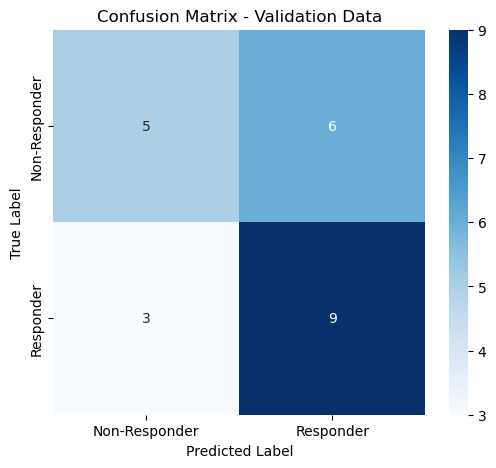

In [26]:
evaluator.plot_confusion_matrix()


As we can see, the model struggles more with predicting **Non-Responders** accurately

c:\Users\user\Documents\Ariel\pycharm_projects\Drug_Response_Analysis\src\models\model_evaluation.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"][:top_n],


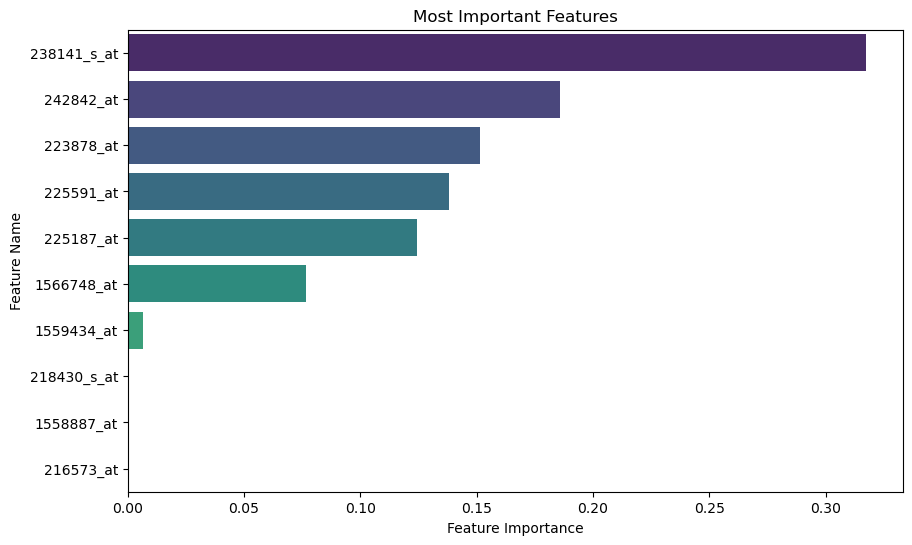

In [27]:
evaluator.plot_feature_importances(top_n=10)

 Analyze a specific instance

Instance #5
Actual label: 1
Predicted label: 1, Probability: 0.8924


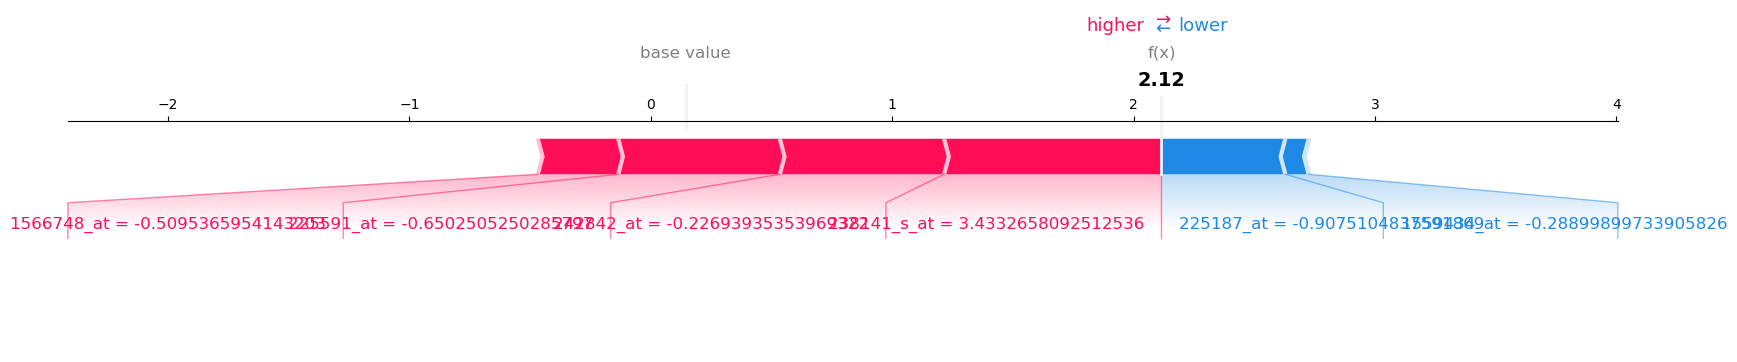

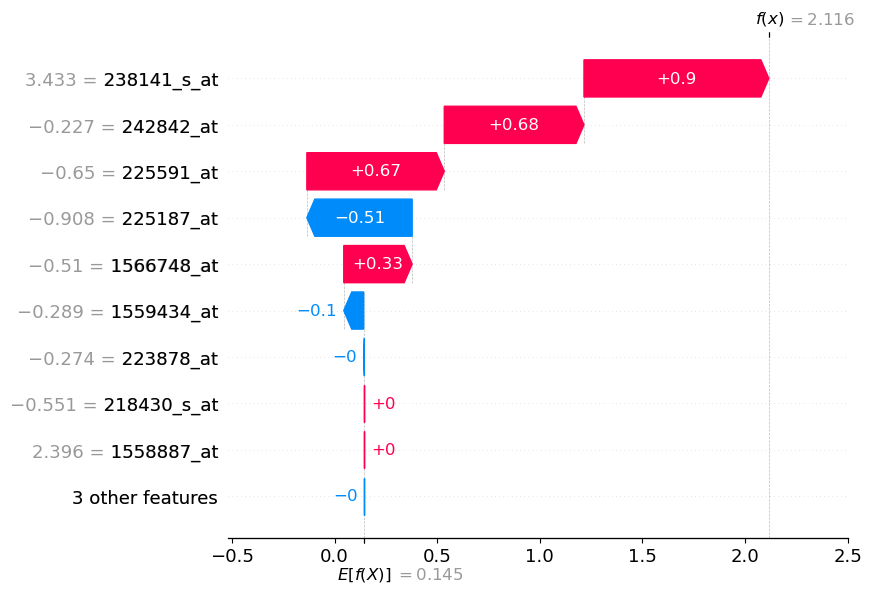

In [28]:
evaluator.analyze_instance_with_shap(5)  # Analyze the 6th instance